## Directed Analysis: Portfolio 5 pt.2 @MLAston

#### Useful previous observations:
>  Fraud transactions occur 1.2% of the time. Solution based on current data will probably overfit since it will "assume" that most transactions are not fraud.

> "Fraud" is more and more likely on high transaction amounts

> "es_leisure" and "es_travel" are the categories most likely to have a fraudulent transaction (also highest amounts)

> The Highest percentage of fraud occurs more in ages<=18 i.e. category 0

### Let's get the data ready

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle


# Import
data = pd.read_csv('bs140513_032310.csv', names= ['step','customer','age','gender','zipcodeOri','merchant','zipMerchant','category','amount','fraud'])
data = data.iloc[1:]
data["amount"] = data["amount"].astype(float)
col_categorical = data.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data[col] = data[col].astype('category')
data[col_categorical] = data[col_categorical].apply(lambda x: x.cat.codes)
# Organize
data = data.drop(["zipcodeOri"], axis = 1)
data = data.drop(["zipMerchant"], axis = 1)
# unique fraud values
data["fraud"]= pd.factorize(data.fraud)[0] % 2
data.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,step,customer,age,gender,merchant,category,amount,fraud
1,156,210,4,2,30,12,4.55,0
2,156,2753,2,2,30,12,39.68,0
3,156,2285,4,1,18,12,26.89,0
4,156,1650,3,2,30,12,17.25,0
5,156,3585,5,2,30,12,35.72,0


In [2]:
data.describe()

,step,customer,age,gender,merchant,category,amount,fraud
count,594643.000000,594643.000000,594643.000000,594643.000000,594643.000000,594643.000000,594643.000000,594643.000000
mean,90.797035,2042.317776,3.014151,1.451089,23.866580,11.066393,37.890135,0.012108
std,49.955379,1185.491845,1.335884,0.503291,8.590215,2.817118,111.402831,0.109369
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,1020.000000,2.000000,1.000000,18.000000,12.000000,13.740000,0.000000
50%,92.000000,2030.000000,3.000000,1.000000,18.000000,12.000000,26.900000,0.000000
75%,133.000000,3059.000000,4.000000,2.000000,30.000000,12.000000,42.540000,0.000000
max,180.000000,4111.000000,7.000000,3.000000,49.000000,14.000000,8329.960000,1.000000


## First approach:
### Feature Engineering: Let's first scale the data using StandardScaler: 
#### Let's attempt to determine the appropriate minimum dimensionality to project the data = the better the features that I prepare and choose, the better the results I will achieve.

#### Preliminary assessment:

Shape of array:  (594643, 7)

# PCA method: 

Explained variance ratios:  [0.18483855 0.14464039 0.14323639 0.1427433  0.14143912 0.13616801
 0.10693423]


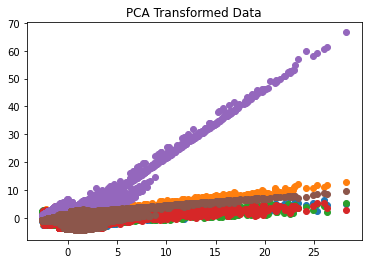



# Factor Analysis Communalities
0    0.054882
1    0.039579
2    0.028083
3    0.030436
4    0.276076
5    0.256914
6    0.080559
Name: Communalities, dtype: float64


                  Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6  \
Variance          0.520376  0.089639  0.066785  0.037493  0.028634  0.023601   
Proportional Var  0.074339  0.012806  0.009541  0.005356  0.004091  0.003372   
Cumulative Var    0.074339  0.087145  0.096686  0.102042  0.106132  0.109504   

                  Factor 7  
Variance          0.000000  
Proportional Var  0.000000  
Cumulative Var    0.109504  


In [3]:
X = data.drop(['fraud'],axis=1)
y = data['fraud']
X_std = StandardScaler().fit_transform(X)
print("Shape of array: ", X_std.shape)

pca = PCA(n_components=7)
pca.fit(X_std)

print("\n# PCA method: ")
print("\nExplained variance ratios: ",pca.explained_variance_ratio_)
X_features = pca.transform(X_std)
plt.title('PCA Transformed Data')
plt.scatter(X_features[:,0], X_features[:,2])
plt.scatter(X_features[:,0], X_features[:,1])
plt.scatter(X_features[:,0], X_features[:,3])
plt.scatter(X_features[:,0], X_features[:,4])
plt.scatter(X_features[:,0], X_features[:,5])
plt.scatter(X_features[:,0], X_features[:,6])
plt.show()

# FactorAnalyzer library to catch the loadings
a = FactorAnalyzer(rotation="oblimin", n_factors=7)
a.fit(X_std)
display = pd.DataFrame( a.loadings_,  columns =['Factor 1', 'Factor 2', 'Factor 3','Factor 4', 'Factor 5', 'Factor 6','Factor 7']) 
# Communalities are proportion of each variable's variance that can be explained by the factors
display['Communalities']= a.get_communalities() 
print("\n\n# Factor Analysis Communalities")
print(display['Communalities'])
print('\n')
print(pd.DataFrame(a.get_factor_variance(),
                   index=['Variance','Proportional Var','Cumulative Var'],
                   columns =['Factor 1', 'Factor 2', 'Factor 3','Factor 4', 'Factor 5', 'Factor 6','Factor 7']))

####  without rotation, using the default number of factors => FA Explains a low 10% of the total variability and using PCA extraction explained variance ratios are quite low as well with:  0.18483855 0.14464039 0.14323639 ....

> The dimensions suggested do not capture enough variance in the data. Across the table it is difficult to interpret the loadings.

### Recall that the "amount" average is around 37,8 and yet the max value is 8329,9
## Let's try using the interquartile range instead of the mean for scaling the data!


Probe assessment. 

# PCA method: 

Explained variance ratios:  [0.60994792 0.31466434 0.01939103 0.01796952 0.01420938 0.01361079
 0.01020702]


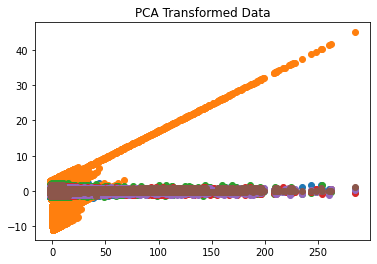



# Factor Analysis Communalities
0    0.054882
1    0.039579
2    0.028083
3    0.030436
4    0.276076
5    0.256914
6    0.080559
Name: Communalities, dtype: float64


                  Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6  \
Variance          0.520376  0.089639  0.066785  0.037493  0.028634  0.023601   
Proportional Var  0.074339  0.012806  0.009541  0.005356  0.004091  0.003372   
Cumulative Var    0.074339  0.087145  0.096686  0.102042  0.106132  0.109504   

                  Factor 7  
Variance          0.000000  
Proportional Var  0.000000  
Cumulative Var    0.109504  


In [4]:
X_std = RobustScaler().fit_transform(X)

pca = PCA(n_components=7)
pca.fit(X_std)
print("\nProbe assessment. ")
print("\n# PCA method: ")
print("\nExplained variance ratios: ",pca.explained_variance_ratio_)
X_features = pca.transform(X_std)
plt.title('PCA Transformed Data')
plt.scatter(X_features[:,0], X_features[:,2])
plt.scatter(X_features[:,0], X_features[:,1])
plt.scatter(X_features[:,0], X_features[:,3])
plt.scatter(X_features[:,0], X_features[:,4])
plt.scatter(X_features[:,0], X_features[:,5])
plt.scatter(X_features[:,0], X_features[:,6])
plt.show()

# FactorAnalyzer library to catch the loadings
a = FactorAnalyzer(rotation="oblimin", n_factors=7)
a.fit(X_std)
display = pd.DataFrame( a.loadings_,  columns =['Factor 1', 'Factor 2', 'Factor 3','Factor 4', 'Factor 5', 'Factor 6','Factor 7']) 
# Communalities are proportion of each variable's variance that can be explained by the factors
display['Communalities']= a.get_communalities() 
print("\n\n# Factor Analysis Communalities")
print(display['Communalities'])
print('\n')
print(pd.DataFrame(a.get_factor_variance(),
                   index=['Variance','Proportional Var','Cumulative Var'],
                   columns =['Factor 1', 'Factor 2', 'Factor 3','Factor 4', 'Factor 5', 'Factor 6','Factor 7']))

### It appears that scaling the data not on the mean but on the interquartile range improves the PCA explanation of the variances significantly:  0.60994792 0.31466434 0.01939103 ... while no significant impact happened in the Factor analysis

> Here I find a promising lead to a good linear combination of some variables but not a significant measurement model of latent variables

### In these results, 0.609, and 0.314 of the variability in the data is explained by PCA1 and PCA2 Both factors together explain 92%, or the variability in the data.

## Let's figure out the right number of factors for PCA


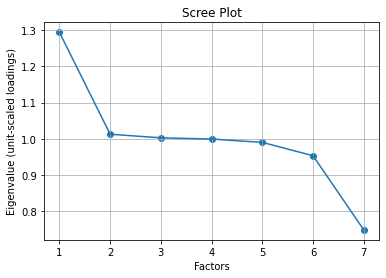


It appears 2 factors >=1% will satisfy


#PCA method: 

Explained variance ratios:  [0.60994792 0.31466434]

#PCA Loadings_

   Factor 1  Factor 2
0     -0.00     -0.00
1      0.00      0.00
2     -0.00      0.00
3     -0.00      0.00
4      0.02     -0.06
5     -0.15      0.99
6      0.99      0.15


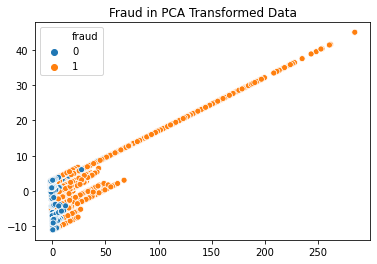

In [5]:
ev, v = a.get_eigenvalues()
plt.scatter(range(1,X_std.shape[1]+1),ev)
plt.plot(range(1,X_std.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue (unit-scaled loadings)')
plt.grid(True)
plt.show()

print("\nIt appears 2 factors >=1% will satisfy\n")
pca = PCA(n_components=2)
pca.fit(X_std)
print("\n#PCA method: ")
print("\nExplained variance ratios: ",pca.explained_variance_ratio_)
pcaLoadings_ = pd.DataFrame(np.round(pca.components_,2)[0], columns=["Factor 1"])
pcaLoadings_["Factor 2"] = np.round(pca.components_,2)[1]
print("\n#PCA Loadings_\n")
print(pcaLoadings_)

X_features = pca.transform(X_std)
plt.title('Fraud in PCA Transformed Data')
sns.scatterplot(X_features[:,0], X_features[:,1],hue=y)
plt.show()

In [6]:
print(X_features.shape)
pca.components_

(594643, 2)


array([[-8.59319628e-05,  8.79339625e-04, -7.71911439e-04,
        -1.78042072e-03,  1.73739525e-02, -1.49107988e-01,
         9.88665974e-01],
       [-1.69397331e-03,  2.51297336e-04,  9.79932544e-04,
         9.51320765e-04, -6.32220408e-02,  9.86672208e-01,
         1.49920410e-01]])


> Overall relationship between the data points is preserved
despite the reduction of dimensions with 92% compatibility.

### Model Building Baseline
#### Linear Algorithms: Logistic regression

Train MSE score: 0.00671951951951952
Test MSE score: 0.0062278228405823095
R2 score logistic regression:  0.4686501604232116


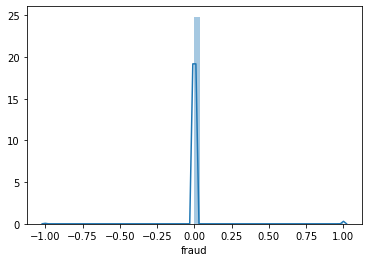

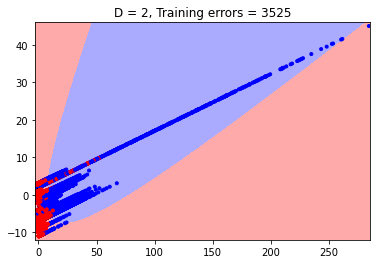

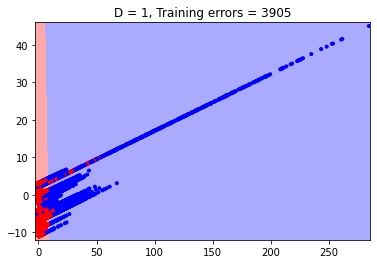

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_features,y,test_size=0.30,random_state=42)

def mapFeature(X1, X2, D, eins):
    if eins:
        Xe = np.c_[np.ones([len(X1), 1]), X1, X2]
    else:
        Xe = np.c_[X1, X2]
    for i in range(2, D + 1):
        for j in range(0, i + 1):
            Xe = np.append(Xe, (X1 ** (i - j) * X2 ** j).reshape(-1, 1), 1)
    return Xe

def mesh_grid_plot(X, y, i):
    h = .05
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    x1, x2 = xx.ravel(), yy.ravel()

    xy_mesh = mapFeature(x1, x2, i, False)
    classes = result.predict(xy_mesh)
    clz_mesh = classes.reshape(xx.shape)

    light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    points = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    plt.pcolormesh(xx, yy, clz_mesh, cmap=light)
    plt.scatter(X[:, 0], X[:, 1], c=y, marker='.', cmap=points)
    

result = LogisticRegression(solver='lbfgs', C=1000, tol=1e-6, max_iter=100000)
result.fit(X_train,y_train)

pred_test = result.predict(X_test)
pred_train = result.predict(X_train)

train =(mean_squared_error(y_train,pred_train))
test =(mean_squared_error(y_test,pred_test))
print("Train MSE score:",train)
print("Test MSE score:",test)
print("R2 score logistic regression: ",r2_score(y_test,pred_test))
sns.distplot(y_test-pred_test) 

Xe = np.c_[X_features[:, 0],
           X_features[:, 1],
           pow(X_features[:, 0], 2),
           X_features[:, 0] * X_features[:, 1],
           pow(X_features[:, 1], 2)]

plt.figure(2)
result = LogisticRegression(solver='lbfgs', C=1000, tol=1e-6, max_iter=100000)
result.fit(Xe, y)
Xe = mapFeature(X_features[:, 0], X_features[:, 1], 2, False)
result.fit(Xe, y)
mesh_grid_plot(Xe, y,2)
plt.title("D = 2, Training errors = " + str(np.sum(result.predict(Xe) != y)))
plt.show()

plt.figure(3)
result = LogisticRegression(solver='lbfgs', C=1000, tol=1e-6, max_iter=100000)
result.fit(X_features, y)
Xe = mapFeature(X_features[:, 0], X_features[:, 1], 1, False)
result.fit(Xe, y)
mesh_grid_plot(Xe, y,1)
plt.title("D = 1, Training errors = " + str(np.sum(result.predict(Xe) != y)))
plt.show()

#### With an MSE that is almost 0 one might think the solution is ideally trained and goal is 100%.
#### => yet upon further inspection, the solution space plot and training errors spell the truth. 
> for 70% of 7200 is 5040 and training errors are between 3500 and 3900 that is quite the poor performance around …31% correctness
## Could this misleading result be due to the choice of algorithm, or the heavily skewed nature of the features?

### First: Let's explore an alternative non-Linear Algorithms
### DecisionTreeRegressor
> decision trees, do a better job at capturing the non-linearity in the data by dividing the space into smaller sub-spaces. Let's see how it performs

******* DecisionTreeRegressor kernel
Best params learned via GridSearch DecisionTreeRegressor(max_depth=8)
******* DecisionTreeRegressor results:

r2_score:  0.6610139059853274
Train MSE score: 0.0037444974668410257
Test MSE score:  0.003973173946238233
Training errors 2791
Test errors 1114


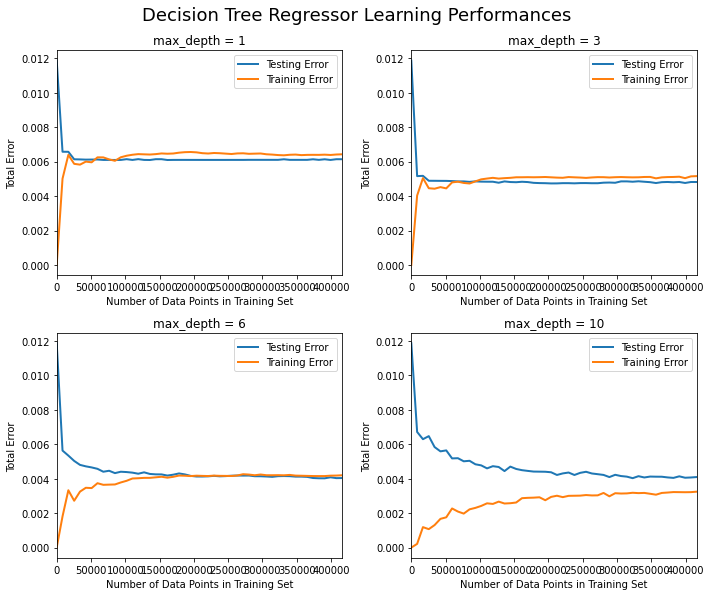

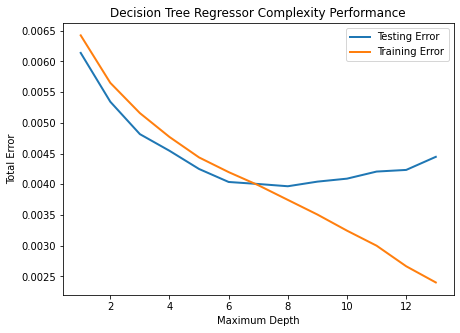

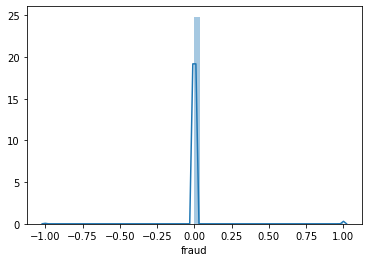

In [8]:
def learning_curves(X_train, y_train, X_test, y_test):
    fig = plt.figure(figsize=(10, 8))
    # We will vary the training set size so that we have 50 different sizes
    sizes = np.rint(np.linspace(1, len(X_train), 50)).astype(int)
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))
    for k, depth in enumerate([1, 3, 6, 10]):
        for i, s in enumerate(sizes):
            regressor = DecisionTreeRegressor(max_depth=depth)
            regressor.fit(X_train[:s], y_train[:s])
            train_err[i] = performance_metric(y_train[:s], regressor.predict(X_train[:s]))
            test_err[i] = performance_metric(y_test, regressor.predict(X_test))
        # Subplot the learning curve graph
        ax = fig.add_subplot(2, 2, k + 1)
        ax.plot(sizes, test_err, lw=2, label='Testing Error')
        ax.plot(sizes, train_err, lw=2, label='Training Error')
        ax.legend()
        ax.set_title('max_depth = %s' % depth)
        ax.set_xlabel('Number of Data Points in Training Set')
        ax.set_ylabel('Total Error')
        ax.set_xlim([0, len(X_train)])
    plt.suptitle('Decision Tree Regressor Learning Performances', fontsize=18, y=1.03)
    plt.tight_layout()
    plt.show()

def model_complexity(X_train, y_train, X_test, y_test):
    max_depth = np.arange(1, 14)
    train_err = np.zeros(len(max_depth))
    test_err = np.zeros(len(max_depth))
    for i, d in enumerate(max_depth):
        regressor = DecisionTreeRegressor(max_depth=d)
        regressor.fit(X_train, y_train)
        train_err[i] = performance_metric(y_train, regressor.predict(X_train))
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))
    plt.figure(figsize=(7, 5))
    plt.title('Decision Tree Regressor Complexity Performance')
    plt.plot(max_depth, test_err, lw=2, label='Testing Error')
    plt.plot(max_depth, train_err, lw=2, label='Training Error')
    plt.legend()
    plt.xlabel('Maximum Depth')
    plt.ylabel('Total Error')
    plt.show()

def performance_metric(y_true, y_predict):
    return mean_squared_error(y_true, y_predict)

print('******* DecisionTreeRegressor kernel')

# Cross validate and fine tune hyper parameters
tuned_params = {"max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9,10]}
optimiser = GridSearchCV(DecisionTreeRegressor(), tuned_params, n_jobs=-1)
optimiser.fit(X_train, y_train)
predictor = optimiser.predict(X_test)
print("Best params learned via GridSearch", optimiser.best_estimator_)

print("******* DecisionTreeRegressor results:\n\nr2_score: ", optimiser.score(X_test, y_test))
preds = optimiser.predict(X_train)
mse = np.sum((preds - y_train) ** 2) / len(preds)
print("Train MSE score:", mse)
print("Test MSE score: ", np.sum((predictor - y_test) ** 2) / len(predictor))

print("Training errors", str(np.sum(result.predict(X_train) != y_train)))
print("Test errors", str(np.sum(result.predict(X_test) != y_test)))

learning_curves(X_train, y_train, X_test, y_test)
model_complexity(X_train, y_train, X_test, y_test)

sns.distplot(y_test-pred_test) 

### It appears that we can produce less errors, an improved r2_score and an MSE that is also almost 0.
### => yet still this is not satisfactory! it is misleading
> for 70% of 7200 is 5040 and training error is 2791 and that is still quite a poor performance of 55,3% very slightly better than a coin toss.

### Let's PIVOT: Initial Approach  rejected!
### Unfortunately, and admittedly, the severly skewed data swamp the accuracy metric.

### ==> We cannot circumvent the nature of the data unless we take an alternative approach.

In this regard, the literature describes handling imbalanced datasets by rating classification errors with the minority class as more important than those with the majority class.


#### Approaches to handle imbalanced classes:
    Random Oversampling: 
   > Useful but the fraudulent transactions can vary.

    Random Undersampling:
   > Balanced distribution but we lose data
   
    Combined Oversampling and Undersampling
   > Examples of popular combinations: 
      SMOTE and Random Undersampling, SMOTE and Edited Nearest Neighbors
    


## Second Approach: Naive Data reSampling
### ML: Random OverSampling of the minority class 1:1

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy : 91.17%


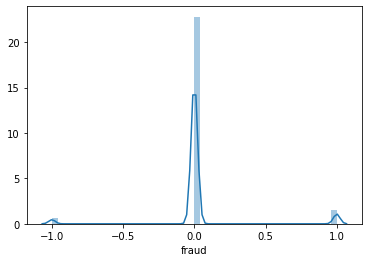

In [9]:
X_origin = data.drop(['fraud'],axis=1)
y_origin = data['fraud']

minority = data.loc[data.fraud == 1] 
majority = data.loc[data.fraud == 0]

minority_oversampled = resample(minority, replace=True, n_samples=580000, random_state=0)
data_oversampled = pd.concat([majority, minority_oversampled])
data_oversampled = shuffle(data_oversampled)
data_oversampled.reset_index(inplace=True, drop=True)

X_oversampled = data_oversampled.drop(['fraud'], axis=1)
y_oversampled = data_oversampled['fraud']

X_train, X_test, y_train, y_test = train_test_split(X_oversampled,y_oversampled,test_size=0.3,random_state=42,shuffle=True,stratify=y_oversampled)

logreg1 = LogisticRegression()
clf1 = logreg1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)

accuracy1 = accuracy_score(y_pred, y_test)
print("Accuracy : %.2f%%" % (accuracy1 * 100.0))
sns.distplot(y_test-y_pred)

### ML: Random underSampling of the majority class 1:1

Accuracy : 91.82%


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


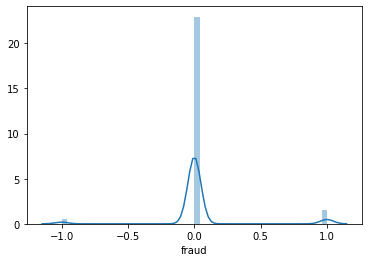

In [10]:
majority_undersampled = resample(majority, replace=True, n_samples=14000, random_state=0)
data_undersampled = pd.concat([majority_undersampled, minority])

data_undersampled = shuffle(data_undersampled)
data_undersampled.reset_index(inplace=True, drop=True)

X_undersampled = data_undersampled.drop(['fraud'], axis=1)
y_undersampled = data_undersampled['fraud']

X_train, X_test, y_train, y_test = train_test_split(X_undersampled,y_undersampled,test_size=0.3,random_state=42,shuffle=True,stratify=y_undersampled)

logreg2 = LogisticRegression()
clf2 = logreg2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
accuracy2 = accuracy_score(y_pred, y_test)
print("Accuracy : %.2f%%" % (accuracy2 * 100.0))
sns.distplot(y_test-y_pred)

### In the literature: A more advanced and possibly more attractive approach matching the data observations considers:

#### Tomek Links undersampling and SMOTE Oversampling:  
  > Tomek Links uses a more restrictive condition resulting in less samples being removed. It requires both samples to be each other's nearest neighbours
  
  > SMOTE synthesizes samples from the minority class rather than creating copies based on those that exist already.

### Let's attempt Combined Oversampling and Undersampling

In [11]:
smotemek = SMOTETomek(sampling_strategy='auto')
x_train_smt, y_train_smt = smotemek.fit_sample(X_origin, y_origin) # original data

data_combined = x_train_smt
data_combined["fraud"]=y_train_smt
data_combined

,step,customer,age,gender,merchant,category,amount,fraud
0,156,210,4,2,30,12,4.550000,0
1,156,2753,2,2,30,12,39.680000,0
2,156,2285,4,1,18,12,26.890000,0
3,156,1650,3,2,30,12,17.250000,0
4,156,3585,5,2,30,12,35.720000,0
...,...,...,...,...,...,...,...,...
1174709,138,2370,2,1,40,13,3647.251725,1
1174710,59,3687,2,1,45,8,358.557564,1
1174711,52,2187,2,1,2,13,315.882207,1
1174712,109,1402,3,2,15,9,323.588970,1


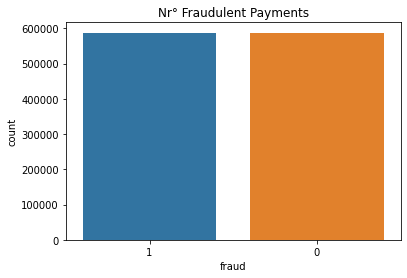

step       -0.019523
customer   -0.007784
age         0.538375
gender      0.857972
merchant    0.009784
category   -0.769541
amount      5.724828
fraud       0.000000
dtype: float64

In [12]:
sns.countplot(x="fraud",data=data_combined, order = data_combined["fraud"].value_counts().index)
plt.title("Nr° Fraudulent Payments")
plt.show()

data_combined.skew()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy : 92.22%


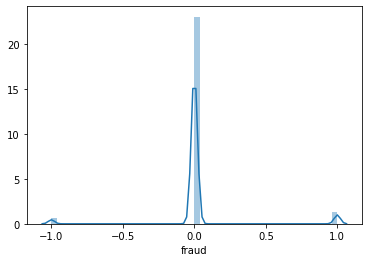

In [13]:
# Let's compare to previous attempts for consistency
X_train, X_test, y_train, y_test = train_test_split(x_train_smt,y_train_smt,test_size=0.3,random_state=42,shuffle=True,stratify=y_train_smt)
X_train= X_train.drop(['fraud'],axis=1)
X_test= X_test.drop(['fraud'],axis=1)
logreg2 = LogisticRegression()
clf2 = logreg2.fit(X_train, y_train)

y_pred = clf2.predict(X_test)
accuracy2 = accuracy_score(y_pred, y_test)
print("Accuracy : %.2f%%" % (accuracy2 * 100.0))
sns.distplot(y_test-y_pred)

#### It appears the Naive Linear regression model performs relatively the same on the three attempts at data resampling!

### => Resampling improved my predictions
## Let's attempt to use better cost-sensitive models instead of linear ones.

In [37]:
# An ensemble of decision trees! where predictions are averaged to produce a single result
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(x_train_smt,y_train_smt,test_size=0.3,random_state=42,shuffle=True,stratify=y_train_smt)
X_train= X_train.drop(['fraud'],axis=1)
X_test= X_test.drop(['fraud'],axis=1)

# decision trees are really helpful because they are easier to interpret and faster to train.
Mytree = DecisionTreeClassifier(max_depth=10)

Mytree.fit(X_train,y_train)
y_pred = Mytree.predict(X_test)

print("****** DecisionTreeClassifier r2_score = ", Mytree.score(X_test, y_test))
print("Classification Report for DecisionTreeClassifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred))

****** DecisionTreeClassifier r2_score =  0.985227643545252
Classification Report for DecisionTreeClassifier: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    176208
           1       0.98      0.99      0.99    176207

    accuracy                           0.99    352415
   macro avg       0.99      0.99      0.99    352415
weighted avg       0.99      0.99      0.99    352415

Confusion Matrix: 
 [[172627   3581]
 [  1629 174578]]


[1.28844539e-03 1.20801017e-03 6.32129134e-04 9.22983641e-03
 7.55531135e-02 1.67674528e-01 7.44413937e-01]


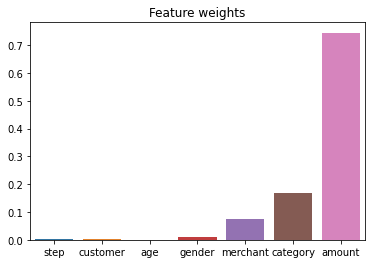

In [36]:
weights = Mytree.feature_importances_
print("W: %.2f%%" % (weights))
columns = X_origin.columns
sns.barplot(columns, weights)
plt.title('Feature weights')
plt.show()

## In conclusion: MyModel does very well 
> 99% F1 score (this score takes both False Positives and False Negatives into account to strike a balance between precision and Recall)
## It is reliable for the bank's benefit!

> Solution accurately predicts whether or not a new payment (i.e. one not in the dataset) was fraudulent with reasonable accuracy.